# Dataset declaration
Custom datasets loads the BRUSH samples in memory, each signal representing a sentence.

In [106]:
import os
from torch.utils.data import Dataset
import numpy as np
import cv2
import math
import pickle
from enum import Enum, auto
from pathlib import Path

class StrokeMode(Enum):
    STROKES = auto()
    SUBSTROKES = auto()

class BrushDataset(Dataset):
    """The BRUSH dataset object is used to retrieve all samples from the BRUSH dataset
    This dataset retrives them as:
    Sample  = Offline image
    Label   = Online signal
    The loading of the dataset is special, as we retrieve only the label in memory and build
    the images at runtime.
    """
    brush_root: str
    display_stats: bool
    save_to_file: bool

    DRAW_COLOR_WHITE = 0
    DRAW_COLOR_BLACK = 255
    DRAW_COLOR_SIZE = 1

    RAW_DIR = "raw"
    GROUPED_STROKES_DIR = "FULL_STROKES"
    GROUPED_SUBSTROKES_DIR = "FULL_SUBSTROKES"
    FOLDER_IMAGES = "offline"
    FOLDER_SIGNALS = "online"
    FILE_IMAGES = "images.npy"
    FILE_SIGNALS = "images.npy"

    strokemode: StrokeMode

    signals: list[list]
    images: list

    size: int

    def __init__(self, brush_root, display_stats: bool = False, save_to_file: bool = True, strokemode: StrokeMode = StrokeMode.STROKES):
        self.brush_root = brush_root
        self.display_stats = display_stats
        self.save_to_file = save_to_file
        self.strokemode = strokemode

        self.signals = []
        self.images = []
        
        self.load_samples()

    #Override
    def __len__(self):
        return len(self.images)

    #Override
    def __getitem__(self, idx):
        if idx >= self.size:
            raise Exception(f"Invalid index: Dataset of size {self.size} has no item at index {idx}")
        image = self.images[idx]
        label = self.signals[idx]
        return image, label
    
    def load_samples(self):
        """Function that tries to retrieve samples form single file. If it cannot, retrieve samples from individual files on disk"""
        try:
            self.load_images_labels()
        except Exception as e:
            print(f"Impossible to retrieve single file, retrieving samples individually")
            self.search_load_samples()
        finally:
            self.size = len(self.images)
            if self.display_stats:
                print(f"Loaded {self.size} data points")

    def search_load_samples(self):
        """This function loads the samples forn disk, creatin the offline image in the process"""
        raw_root = os.path.join(self.brush_root, self.RAW_DIR)
        try:
            writer_ids = os.listdir(raw_root)
            total_writers = len(writer_ids)
            if self.display_stats:
                print(f"Loading {total_writers} writers")
        except Exception as e:
            print(f"Impossible to read root folder {self.brush_root}")
            raise e
        
        i = 0
        for writer_id in writer_ids:
            i += 1
            if i >= 2:
                break
            writer_path = os.path.join(raw_root, writer_id)
            #Each drawin is present in three examplaries: n, n_resample20 and n_resample25
            #base dataloader selects default (10ms)
            drawing_ids = [name for name in os.listdir(writer_path) if "_" not in name and ".npy" not in name]

            if self.display_stats:
                print(f"{i}/{total_writers}: Detected {len(drawing_ids)} drawings")

            for drawing_id in drawing_ids:
                signal_path = os.path.join(writer_path, drawing_id)
                sentence, signal, char_label = self.load_signal(signal_path)

                if self.strokemode is StrokeMode.SUBSTROKES:
                    signals = self.stroke_signal_to_substroke(signal, align_substrokes=True, left_padding=5)
                    self.signals.extend(signals)
                    self.images.extend([self.create_image(signal) for signal in signals])
                else:
                    self.signals.append(signal)
                    self.images.append(self.create_image(signal))
                
        if self.save_to_file:
            self.save_images_labels_single_file()

    def load_signal(self, filepath: str) -> tuple[str, list, list]:
        """Load an online sinal from a filepath
        Args
        -----
            Filepath: The name of the file to load from
            
        Returns
        -----
            - str: Written sentence as string
            - list: Signal of x, y, penUp
            - list: List of one-hot vectors with same length as signal identifying charachter of point
        """
        with open(filepath, 'rb') as f:
            [sentence, signal, label] = pickle.load(f)

        signal = (np.rint(signal)).astype(int)

        return sentence, signal, label

    @classmethod
    def create_image(cls, signal: list[int, int, bool]):
        """Create the image associated with the given signal."""
        max_h =  int(math.ceil(max(signal[:, 0])))
        max_w = int(math.ceil(max(signal[:, 1])))

        canvas = np.ascontiguousarray(np.full((max_w + 1, max_h + 1), cls.DRAW_COLOR_BLACK), dtype=np.uint8)

        #Draw lines from point (t-1) to current point (t) IFF the pen was not up. start with penup
        #as we start from point 0.
        draw_current_stroke = False
        for x, y, eos in signal:
            if draw_current_stroke:
                cv2.line(canvas, (last_x, last_y), (x, y), cls.DRAW_COLOR_WHITE, cls.DRAW_COLOR_SIZE) 
            last_x, last_y, draw_current_stroke = x, y, not eos
        
        return canvas

    @classmethod
    def stroke_signal_to_substroke(cls, signal: list, align_substrokes: bool = True, left_padding: int = 5) -> list[list]:
        """Provided an online signal, return a list of its substrokes separated by PENUP
        
        args
        -----
            signal: list - The signal as (x,y,penup) array
            align_substrokes: bool - Whether to align the substrokes at the left
            h_padding: 
        """
        substrokes = []

        start_idx = 0
        end_idx = 0

        #Cut the stroke each time the pen is up to obtain substrokes
        for x, y, penup in signal:
            end_idx += 1
            if penup:
                substroke = signal[start_idx:end_idx]

                # If a substroke starts at x=40, it can be re-placed at 0. 
                # This is be done via substracting the min X value to each value of the signal
                if align_substrokes:
                    min_x = min(substroke[:, 0])
                    substroke[:, 0] -= min_x

                # Add a left padding
                if left_padding > 0:
                    substroke[:, 0] += left_padding
                
                substrokes.append(substroke)
                start_idx = end_idx

        return substrokes

    def load_images_labels(self):
        """Load all images and labels at once"""
        strokemode_folder = self.GROUPED_STROKES_DIR if self.strokemode is StrokeMode.STROKES else self.GROUPED_SUBSTROKES_DIR
        
        image_path = os.path.join(self.brush_root, strokemode_folder, self.FOLDER_IMAGES, self.FILE_IMAGES)
        signal_path = os.path.join(self.brush_root, strokemode_folder, self.FOLDER_SIGNALS, self.FILE_SIGNALS)
        print(f"Trying to retrive files at {image_path}, {signal_path}")

        with open(image_path, "rb") as f:
            images = np.load(f, allow_pickle=True)
        with open(signal_path, "rb") as f:
            signals = np.load(f, allow_pickle=True)
        
        self.images = images
        self.signals = signals

    def save_images_labels_single_file(self):
        """Save all images and labels at once"""
        strokemode_folder = self.GROUPED_STROKES_DIR if self.strokemode is StrokeMode.STROKES else self.GROUPED_SUBSTROKES_DIR
        
        image_path = os.path.join(self.brush_root, strokemode_folder, self.FOLDER_IMAGES)
        signal_path = os.path.join(self.brush_root, strokemode_folder, self.FOLDER_SIGNALS)

        Path(image_path).mkdir(parents=True, exist_ok=True)
        Path(signal_path).mkdir(parents=True, exist_ok=True)

        image_folder = os.path.join(image_path, self.FILE_IMAGES)
        signal_folder = os.path.join(signal_path, self.FILE_SIGNALS)

        if self.display_stats:
            print(f"Saving images to {image_path}, signals to {signal_path}")

        images_to_save = np.array(self.images, dtype="object")
        signale_to_save = np.array(self.signals, dtype="object")

        with open(image_folder, "wb") as f:
            np.save(f, images_to_save)
        with open(signal_folder, "wb") as f:
            np.save(f, signale_to_save)

# Test dataset

In [32]:
BRUSH_ROOT = "../../data/handwriting/BRUSH"

import time
start_time = time.time()
dataset = BrushDataset(brush_root=BRUSH_ROOT, display_stats=True, save_to_file=False)
print("--- %s seconds ---" % (time.time() - start_time))

print(f"Size of dataset: {dataset.size}")

Trying to retrive files at ../../data/handwriting/BRUSH/FULL_STROKES/offline/images.npy, ../../data/handwriting/BRUSH/FULL_STROKES/online/images.npy
Loaded 163 data points
--- 0.19539213180541992 seconds ---
Size of dataset: 163


In [28]:
BRUSH_ROOT = "../../data/handwriting/BRUSH"

import time
start_time = time.time()
dataset = BrushDataset(brush_root=BRUSH_ROOT, display_stats=True, save_to_file=True)
print("--- %s seconds ---" % (time.time() - start_time))

print(f"Size of dataset: {dataset.size}")

Loaded 163 data points
--- 0.21331024169921875 seconds ---
Size of dataset: 163


In [29]:
BRUSH_ROOT = "../../data/handwriting/BRUSH"

import time
start_time = time.time()
dataset = BrushDataset(brush_root=BRUSH_ROOT, display_stats=True, save_to_file=False)
print("--- %s seconds ---" % (time.time() - start_time))

print(f"Size of dataset: {dataset.size}")

Loaded 163 data points
--- 0.19754385948181152 seconds ---
Size of dataset: 163


Results of dataset creation
- Building images from signals:
- Building and saving images to file:
- Loading from gile:

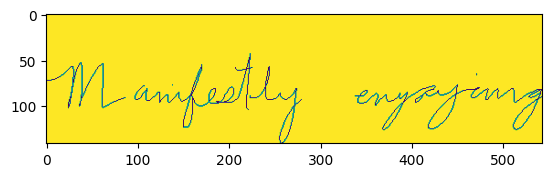

In [25]:
import random
import matplotlib.pyplot as plt

n = random.randint(0, dataset.size)

image, signal = dataset[n]

plt.imshow(image)
plt.show()

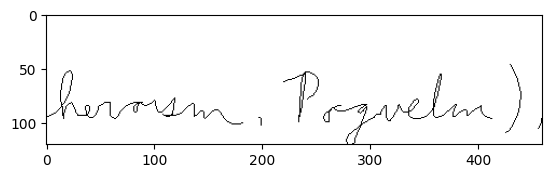

Length of signal: (520, 3)
Length of substrokes: [(217, 3), (8, 3), (42, 3), (232, 3), (14, 3), (7, 3)]
Number of images: 6


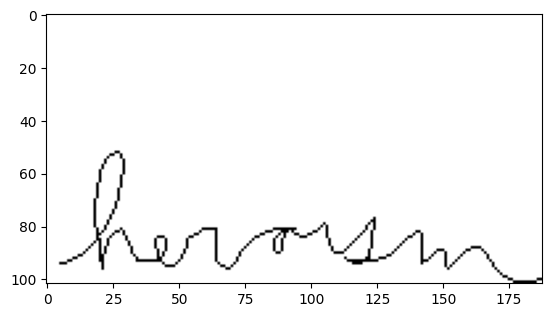

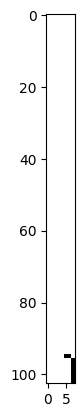

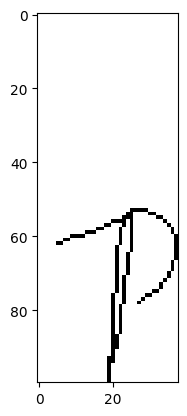

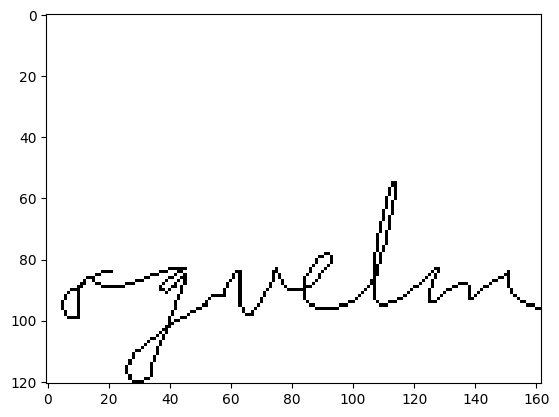

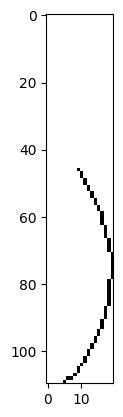

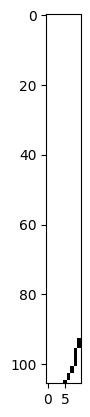

In [108]:
n = random.randint(0, dataset.size)

image, signal = dataset[n]

plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.show()

print(f"Length of signal: {signal.shape}")

substrokes = BrushDataset.stroke_signal_to_substroke(signal, align_substrokes=True, left_padding=5)

print(f"Length of substrokes: {[sbs.shape for sbs in substrokes]}")

print(f"Number of images: {len(substrokes)}")
for substroke in substrokes:
    plt.imshow(BrushDataset.create_image(substroke), cmap='gray', vmin=0, vmax=255)
    plt.show()

In [82]:
BRUSH_ROOT = "../../data/handwriting/BRUSH"

import time
start_time = time.time()
BrushDataset(brush_root=BRUSH_ROOT, display_stats=True, save_to_file=True, strokemode=StrokeMode.SUBSTROKES)
print("--- %s seconds ---" % (time.time() - start_time))

print(f"Size of dataset: {dataset.size}")

Trying to retrive files at ../../data/handwriting/BRUSH/FULL_SUBSTROKES/offline/images.npy, ../../data/handwriting/BRUSH/FULL_SUBSTROKES/online/images.npy
Impossible to retrieve single file, retrieving samples individually
Loading 170 writers
1/170: Detected 163 drawings
Saving images to ../../data/handwriting/BRUSH/FULL_SUBSTROKES/offline, signals to ../../data/handwriting/BRUSH/FULL_SUBSTROKES/online
Loaded 1700 data points
--- 2.6180825233459473 seconds ---
Size of dataset: 163


In [83]:
BRUSH_ROOT = "../../data/handwriting/BRUSH"

import time
start_time = time.time()
dataset_substroke = BrushDataset(brush_root=BRUSH_ROOT, display_stats=True, save_to_file=False, strokemode=StrokeMode.SUBSTROKES)
print("--- %s seconds ---" % (time.time() - start_time))

print(f"Size of dataset: {dataset_substroke.size}")

Trying to retrive files at ../../data/handwriting/BRUSH/FULL_SUBSTROKES/offline/images.npy, ../../data/handwriting/BRUSH/FULL_SUBSTROKES/online/images.npy
Loaded 1700 data points
--- 0.38769030570983887 seconds ---
Size of dataset: 1700


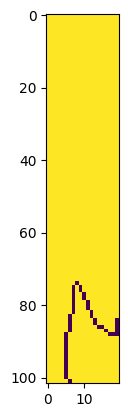

In [95]:
import random
import matplotlib.pyplot as plt

n = random.randint(0, dataset_substroke.size)

image, signal = dataset_substroke[n]

plt.imshow(image)
plt.show()